# Nigerian University Dropout Risk Predictor using XGBoost

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.metrics import mean_absolute_error, mean_squared_error,explained_variance_score, r2_score,confusion_matrix, roc_auc_score,accuracy_score
import shap

## Data Preparation

In [ ]:
# Loading the dataset
df = pd.read_csv('student_dataset_extended3.csv')


FileNotFoundError: [Errno 2] No such file or directory: 'student_dataset_extended3.csv'

In [ ]:
df.isna().sum()

In [ ]:
df.head()

In [ ]:
df.info()

In [ ]:
df.describe()

## Feature Engineering

In [1]:
# Creating new features from existing features
df['Financial_Stress'] = df['Parental_Income_Level'] / df['Inflation_Rate'] 

df['Attendance_Compliance'] = np.where(df['Attendance'] >= 75, 1, 0)

df['Rural_Disadvantage'] = np.where(df['Residence_Location'] == 'Rural', 1, 0)


NameError: name 'df' is not defined

In [ ]:
# Create target variable (Dropout Risk) - following research standards
df['Dropout_Risk'] = np.where(
        (df['GPA'] < 1.5) | 
        (df['Course_Failures'] > 4) | 
        (df['Attendance'] < 70), 1, 0)

## Data Preprocessing

In [ ]:
# Encode categorical variables
cat_colms = ['Gender','Marital_Status', 'Course_Chosen', 'Residence_Location']
label_encoders = {}

for col in cat_colms:
    leb = LabelEncoder()
    df[col] = leb.fit_transform(df[col])
    label_encoders[col] = leb


In [ ]:
df.columns

In [ ]:
# Selected features 
features = [
    'Age', 'Gender', 'Course_Chosen', 'Residence_Location','Semester_Average_Grade',
    'Parental_Income_Level', 'Attendance', 'Marital_Status','Course_Failures',
    'Financial_Stress', 'Attendance_Compliance', 'Rural_Disadvantage'
]

X = df[features]
y = df['Dropout_Risk']

## Train-Test Split

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


##  XGBoost Model Training 

In [ ]:
model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=300,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),
    random_state=42,
    eval_metric='auc',
    early_stopping_rounds=10  
)


In [ ]:
# Train with evaluation set
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=True
)

## Model Evaluation

In [ ]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]
y_pred_new = (y_proba >= 0.2).astype(int)

## Classification Report

In [ ]:
print(classification_report(y_test, y_pred_new))

## Confussion Matrix Display

In [ ]:
conf_mx = confusion_matrix(y_test, y_pred_new)

In [ ]:
conf_mx

In [ ]:
cmx_dsp = ConfusionMatrixDisplay(confusion_matrix = conf_mx, display_labels = ['Not At Risk', 'At Risk'])

In [ ]:
cmx_dsp.plot()
plt.title('Student Dropout Prediction - Confusion Matrix\n', 
          fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('Actual Label', fontsize=12)

plt.show()

In [ ]:
# Evaluation Metrics
print("\nAUC-ROC Score:", roc_auc_score(y_test, y_proba))

The Area Under the ROC Curve(AUC) is the evaluation metric used during training and validation, 
as it is useful for imbalanced classification

In [ ]:
# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

## The Coefficient Of Determination(R2)

In [ ]:
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)

In [ ]:
print(f"Train R²: {train_r2:.3f}, Test R²: {test_r2:.3f}")
print(f"Train RMSE: {train_rmse:.3f}, Test RMSE: {test_rmse:.3f}")

The R2 is a statistical measure indicating how well the model explains the variance of the target variable.
It ranges from 0 to 1, values is closer to 1 indicates better fit while values closer to 0 indicates poor fit.
Therefor, a high R2 indicates that the model learned the data training data well.

## Feature Importance Plot

In [ ]:
# Top 10 Feature Importance
xgb.plot_importance(model, max_num_features=10)
plt.title('Student Dropout Risk - Feature Importance')
plt.show()

In [2]:
# Your confusion matrix data
cmx = np.array([[438  , 3],
               [ 63, 496]])

NameError: name 'np' is not defined

In [27]:
# Calculate metrics
total = np.sum(cmx)
accuracy = np.trace(cmx) / total
precision = cmx[1,1] / (cmx[1,1] + cmx[0,1]) if (cmx[1,1] + cmx[0,1]) > 0 else 0
recall = cmx[1,1] / (cmx[1,1] + cmx[1,0]) if (cmx[1,1] + cmx[1,0]) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0


In [28]:
accuracy

0.934

In [29]:
cmx[1,1] / (cmx[1,1] + cmx[0,1])

0.9939879759519038

In [30]:
cmx[1,1] + cmx[0,1]

499

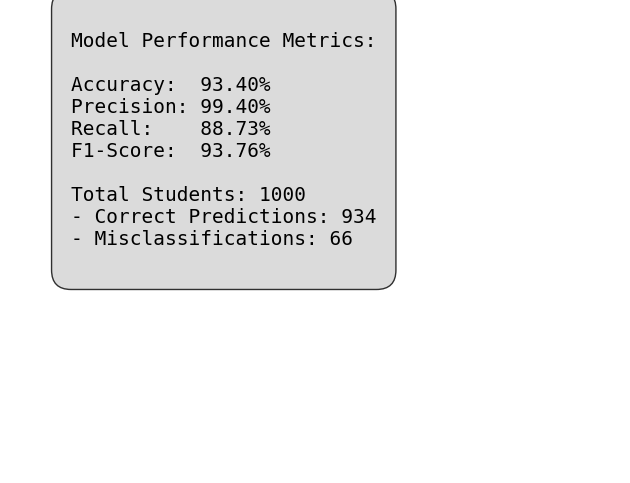

In [33]:
# Add metrics text box
metrics_txt = f"""
Model Performance Metrics:

Accuracy:  {accuracy:.2%}
Precision: {precision:.2%}
Recall:    {recall:.2%}
F1-Score:  {f1_score:.2%}

Total Students: {total}
- Correct Predictions: {np.trace(cmx)}
- Misclassifications: {total - np.trace(cmx)}
"""

plt.text(0.1, 0.9, metrics_txt, fontsize=14, family='monospace',
         bbox=dict(boxstyle="round,pad=1.0", facecolor="lightgray", 
        edgecolor="black", alpha=0.8))
plt.axis('off')

plt.tight_layout()
plt.show()

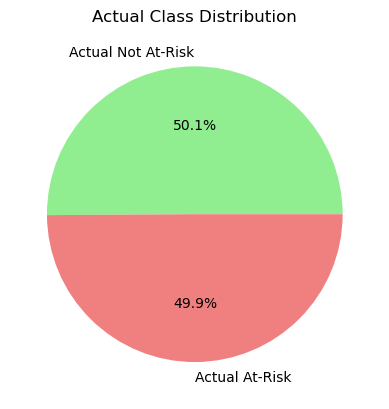

In [34]:
# Class distribution
class_distribution = [cmx[0,0] + cmx[1,0], cmx[0,1] + cmx[1,1]]
plt.pie(class_distribution, labels=['Actual Not At-Risk', 'Actual At-Risk'], 
        autopct='%1.1f%%', colors=['lightgreen', 'lightcoral'])
plt.title('Actual Class Distribution')
plt.show()

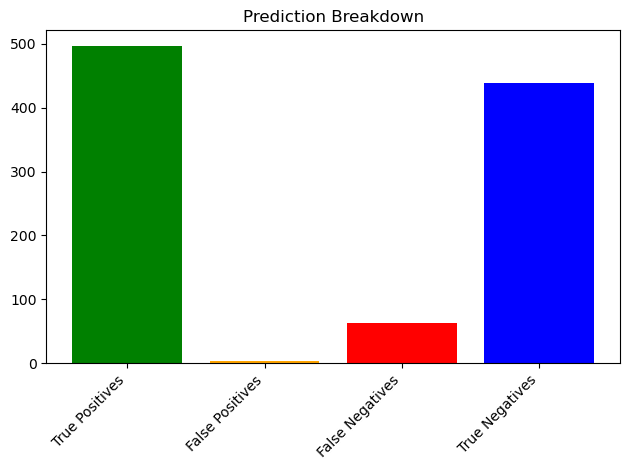

In [35]:
# Error analysis
error_types = ['True Positives', 'False Positives', 'False Negatives', 'True Negatives']
error_counts = [cmx[1,1], cmx[0,1], cmx[1,0], cmx[0,0]]
colors = ['green', 'orange', 'red', 'blue']

plt.bar(error_types, error_counts, color=colors)
plt.title('Prediction Breakdown')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [36]:
print(f"\n Model successfully identified {cmx[1,1]} at-risk students")
print(f"\n {cmx[1,0]} at-risk students were missed (False Negatives)")
print(f"\n {cmx[0,0]} safe students correctly classified")


 Model successfully identified 496 at-risk students

 63 at-risk students were missed (False Negatives)

 438 safe students correctly classified


In [41]:
import joblib
joblib.dump(model, 'model.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')

['label_encoders.pkl']

In [40]:
# Also save the feature names for reference
import json
feature_names = list(X.columns)
with open('model_features.json', 'w') as f:
    json.dump(feature_names, f)
print("✅ Feature names saved as 'model_features.json'")

✅ Feature names saved as 'model_features.json'


## Example Prediction

In [35]:
new_student = {
    'Age': 22,
    'Gender': 'Female',
    'Course_Chosen': 'Engineering',
    'Residence_Location': 'Rural',
    'Parental_Income_Level': 50000,
    'Attendance': 30,
    'Course_Failures': 2,
    'Marital_Status': 'Single',
    'Semester_Average_Grade' : 2.10
}


In [36]:
# Preprocess
new_df = pd.DataFrame([new_student])
for col in cat_colms:
    new_df[col] = label_encoders[col].transform(new_df[col])


In [37]:
# Add engineered features
new_df['Financial_Stress'] = new_df['Parental_Income_Level'] / df['Inflation_Rate']
new_df['Attendance_Compliance'] = np.where(new_df['Attendance'] >= 75, 1, 0)
new_df['Rural_Disadvantage'] = np.where(new_df['Residence_Location'] == 'Rural', 1, 0)


In [38]:
# Predict
risk = model.predict(new_df[features])
risk_proba = model.predict_proba(new_df[features])[:, 1][0]

In [39]:
print(f"\nPredicted Dropout Risk: {'HIGH RISK' if risk[0] == 1 else 'LOW RISK'}")
print(f"Probability: {risk_proba:.2%}")


Predicted Dropout Risk: HIGH RISK
Probability: 96.14%


In [ ]:
previous performance metrics
model performance metrics:
Accuracy:  82.30
Precision:  100.00
Recall:     64.67
F1-Score:   78.55
Total Students: 1000
Correct predictions: 823
Misclassifications: 177

In [ ]:
@"
Flask==2.3.3
Flask-SQLAlchemy==3.0.5
Flask-Login==0.6.2
Flask-WTF==1.1.1
Flask-Mail==0.9.1
python-dotenv==1.0.0
pandas==2.0.3
numpy==1.24.3
scikit-learn==1.3.0
xgboost==1.7.6
joblib==1.3.2
gunicorn==21.2.0
"@ | Out-File -FilePath "requirements.txt" -Encoding UTF8

In [ ]:
print(f"   - Resources can be focused on truly at-risk students")
print(f"   - These need manual review and additional monitoring")
print(f"   - Potential dropouts prevented with early intervention")

In [ ]:
# Additional detailed analysis
print("="*60)
print("DETAILED PERFORMANCE ANALYSIS")
print("="*60)

print(f"\n📊 Overall Accuracy: {accuracy:.2%}")
print(f"✅ Correctly Identified: {np.trace(cm)} students")
print(f"❌ Misclassified: {total - np.trace(cm)} students")

print(f"\n🎯 Precision (At-Risk): {precision:.2%}")
print("   - When model predicts 'At-Risk', how often it's correct")

print(f"\n🔍 Recall (Sensitivity): {recall:.2%}")
print("   - What percentage of actual at-risk students were identified")

print(f"\n⭐ F1-Score: {f1_score:.2%}")
print("   - Balance between Precision and Recall")

# Breakdown by class
safe_precision = cm[0,0] / (cm[0,0] + cm[1,0]) if (cm[0,0] + cm[1,0]) > 0 else 0
safe_recall = cm[0,0] / (cm[0,0] + cm[0,1]) if (cm[0,0] + cm[0,1]) > 0 else 0

print(f"\n{'='*40}")
print("CLASS-WISE PERFORMANCE")
print(f"{'='*40}")

print(f"\n🏫 Safe Students (Class 0):")
print(f"   - Precision: {safe_precision:.2%}")
print(f"   - Recall: {safe_recall:.2%}")
print(f"   - Correct: {cm[0,0]}/{cm[0,0] + cm[1,0]}")

print(f"\n🚨 At-Risk Students (Class 1):")
print(f"   - Precision: {precision:.2%}")
print(f"   - Recall: {recall:.2%}")
print(f"   - Correct: {cm[1,1]}/{cm[1,1] + cm[1,0]}")

In [3]:
pip install --upgrade pip


   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
    --------------------------------------- 0.0/1.8 MB 77.0 kB/s eta 0:00:23
    --------------------------------------- 0.0/1.8 MB 77.0 kB/s eta 0:00:23
    --------------------------------------- 0.0/1.8 MB 77.0 kB/s eta 0:00:23
    --------------------------------------- 0.0/1.8 MB 77.0 kB/s eta 0:00:23
    --------------------------------------- 0.0/1.8 MB 77.0 kB/s eta 0:00:23
   - -------------------------------------- 0.1/1.8 MB 99.2 kB

ERROR: THESE PACKAGES DO NOT MATCH THE HASHES FROM THE REQUIREMENTS FILE. If you have updated the package versions, please update the hashes. Otherwise, examine the package contents carefully; someone may have tampered with them.
    unknown package:
        Expected sha256 6d67a2b4e7f14d8b31b8b52648866fa717f45a1eb70e83002f4331d07e953717
             Got        b3cffb3ebfb20b4dc10d6b756237f359c67a39047b110aeda9032e938412d95e



In [4]:
pip install lightgbm 

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
    --------------------------------------- 0.0/1.5 MB 330.3 kB/s eta 0:00:05
    --------------------------------------- 0.0/1.5 MB 435.7 kB/s eta 0:00:04
    --------------------------------------- 0.0/1.5 MB 435.7 kB/s eta 0:00:04
   - -------------------------------------- 0.1/1.5 MB 297.7 kB/s eta 0:00:05
   -- ------------------------------------- 0.1/1.5 MB 403.5 kB/s eta 0:00:04
   -- ------------------------------------- 0.1/1.5 MB 403.5 kB/s eta 0:00:04
   --- ------------------------------------ 0.1/1.5 MB 343.4 kB/s eta 0:00:04
   --- ------------------------------------ 0.1/1.5 MB 341.3 kB/s eta 0:00:04
   ------- -------------------------------- 0.3/1.5 MB 567.7 kB/s eta 0:00:03
   ------- -------------------------------- 0.3/1.5 MB 567.7 kB/s eta 0:00:03
   -------- ------------------------------- 0.3/1.5 MB 559.2 kB/s eta 0:00:03
   ---------- ----------------------------- 0.4/1.5 MB 573.4 kB/s eta 0:0

In [27]:
!pip install xgboost

   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/56.8 MB 109.5 kB/s eta 0:08:39
   ---------------------------------------- 0.0/56.8 MB 109.5 kB/s eta 0:08:39
   ---------------------------------------- 0.0/56.8 MB 109.5 kB/s eta 0:08:39
   ---------------------------------------- 0.0/56.8 MB 93.7 kB/s eta 0:10:07
   ---------------------------------------- 0.1/56.8 MB 148.8 kB/s eta 0:06:22
   ---------------------------------------- 0.1/56.8 MB 194.1 kB/s eta 0:04:53
   ---------------------------------------- 0.1/56.8 MB 194.1 kB/s eta 0:04:53
   ---------------------------------------- 0.1/56.8 MB 194.1 kB/s eta 0:04:53
   ---------------------------------------- 0.1/56.8 MB 212.1 kB/s eta 0:04:28
   -------

In [29]:
!pip install shap

   ---------------------------------------- 0.0/544.4 kB ? eta -:--:--
   ---------------------------------------- 0.0/544.4 kB ? eta -:--:--
    --------------------------------------- 10.2/544.4 kB ? eta -:--:--
   -- ------------------------------------ 30.7/544.4 kB 640.0 kB/s eta 0:00:01
   -- ------------------------------------ 30.7/544.4 kB 640.0 kB/s eta 0:00:01
   -- ------------------------------------ 30.7/544.4 kB 640.0 kB/s eta 0:00:01
   -- ------------------------------------ 30.7/544.4 kB 640.0 kB/s eta 0:00:01
   ----- --------------------------------- 71.7/544.4 kB 280.5 kB/s eta 0:00:02
   ------- ------------------------------ 112.6/544.4 kB 409.6 kB/s eta 0:00:02
   -------- ----------------------------- 122.9/544.4 kB 343.4 kB/s eta 0:00:02
   -------- ----------------------------- 122.9/544.4 kB 343.4 kB/s eta 0:00:02
   -------------- ----------------------- 204.8/544.4 kB 478.0 kB/s eta 0:00:01
   -------------- ----------------------- 204.8/544.4 kB 478.0 kB/